In [11]:
import pandas as pd
from pathlib import Path
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
PROJECT_ROOT= Path.cwd()
data_path = Path(PROJECT_ROOT,"data/processed/Coffee_Shop_Sales.csv")
data = pd.read_csv(data_path)
data.head()
RESULT_DIR = Path(PROJECT_ROOT,"src/results")



In [12]:
data.info()
cols_validas = [
    c for c in data.select_dtypes(include='number').columns
    if not (c.lower().startswith("id") or c.lower().endswith("id"))
]

data[cols_validas].describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   transaction_id        149116 non-null  int64  
 1   fecha_transaccion     149116 non-null  object 
 2   hora_transaccion      149116 non-null  object 
 3   cantidad_transaccion  149116 non-null  int64  
 4   id_tienda             149116 non-null  int64  
 5   ubicacion_tienda      149116 non-null  object 
 6   id_producto           149116 non-null  int64  
 7   precio_unitario       149116 non-null  float64
 8   categoria_producto    149116 non-null  object 
 9   tipo_producto         149116 non-null  object 
 10  product_detail        149116 non-null  object 
 11  tiempo_transaccion    149116 non-null  object 
 12  total_venta           149116 non-null  float64
dtypes: float64(2), int64(4), object(7)
memory usage: 14.8+ MB


,count,mean,std,min,25%,50%,75%,max
cantidad_transaccion,149116.0,1.438276,0.542509,1.0,1.0,1.00,2.00,8.0
precio_unitario,149116.0,3.382219,2.658723,0.8,2.5,3.00,3.75,45.0
total_venta,149116.0,4.686367,4.227099,0.8,3.0,3.75,6.00,360.0


### 2.a Calcular y mostrar los siguientes estadísticos:
▪ Medidas de tendencia central: media, mediana y moda.  
▪ Medidas de dispersión: varianza, desviación estándar y rango.  
▪ Percentiles y cuartiles (25, 50 y 75)   
▪ Intervalo de confianza (95%) para la media de una variable numérica
relevante.

In [13]:
confidence_level = 0.95
resultados = []  # lista para guardar resultados de cada columna

for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]) and not (col.lower().startswith("id") or col.lower().endswith("id")):
        sample = data[col].dropna()  # eliminamos nulos
        n = len(sample)
        mean = np.mean(sample)
        std_err = stats.sem(sample)

        intervalo = stats.t.interval(confidence_level, n-1, loc=mean, scale=std_err)
        intervalo = tuple(round(x, 2) for x in intervalo)

        proc_stats = {
            "Variable": col,
            "Media": round(sample.mean(), 2),
            "Mediana": round(sample.median(), 2),
            "Moda": round(sample.mode()[0], 2),
            "Varianza": round(sample.var(), 2),
            "Desviación estándar": round(sample.std(), 2),
            "Rango": round(sample.max() - sample.min(), 2),
            "Q25": round(np.percentile(sample, 25), 2),
            "Q50": round(np.percentile(sample, 50), 2),
            "Q75": round(np.percentile(sample, 75), 2),
            "IC 95% Inferior": round(intervalo[0], 2),
            "IC 95% Superior": round(intervalo[1], 2)
        }

        resultados.append(proc_stats)

# Crear un DataFrame con todos los resultados
df_estadisticas = pd.DataFrame(resultados)

# Mostrar
df_estadisticas

,Variable,Media,Mediana,Moda,Varianza,Desviación estándar,Rango,Q25,Q50,Q75,IC 95% Inferior,IC 95% Superior
0,cantidad_transaccion,1.44,1.00,1.0,0.29,0.54,7.0,1.0,1.00,2.00,1.44,1.44
1,precio_unitario,3.38,3.00,3.0,7.07,2.66,44.2,2.5,3.00,3.75,3.37,3.40
2,total_venta,4.69,3.75,3.0,17.87,4.23,359.2,3.0,3.75,6.00,4.66,4.71


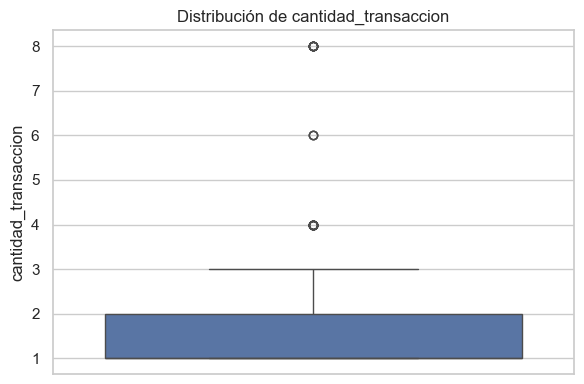

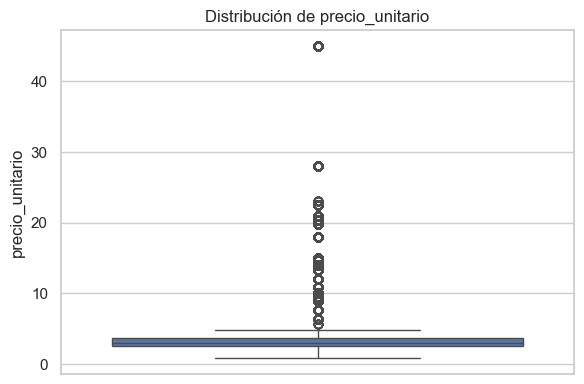

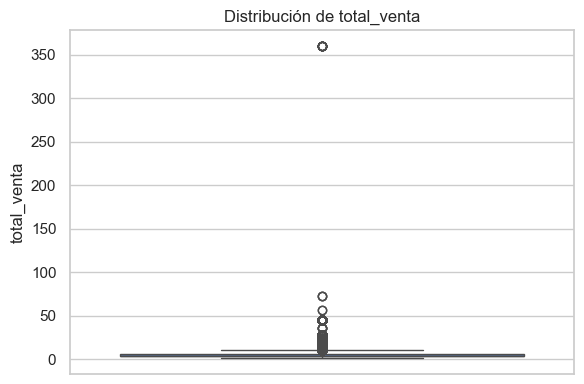

In [14]:
# Boxplots para cada columna numérica (excluyendo identificadores y fechas)
excluir = {
    "transaction_id", "fecha_transaccion", "hora_transaccion", "id_tienda", "id_producto"
}
numericas = [
    c for c in data.select_dtypes(include="number").columns
    if c not in excluir
]

for col in numericas:
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=data, y=col, color="#4C72B0")
    plt.title(f"Distribución de {col}")
    plt.tight_layout()
    fig.savefig(RESULT_DIR / f"boxplot_{col}.jpg", dpi=300, format="jpg")
    plt.show()

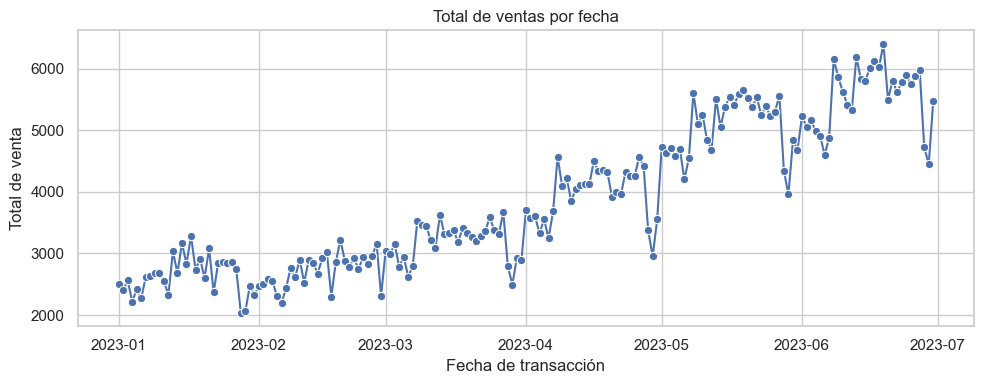

In [15]:
# Serie temporal: total_venta por fecha_transaccion
data["fecha_transaccion"] = pd.to_datetime(data["fecha_transaccion"])
ventas_diarias = (
    data.groupby("fecha_transaccion", as_index=False)["total_venta"]
    .sum()
)
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=ventas_diarias, x="fecha_transaccion", y="total_venta", marker="o")
plt.title("Total de ventas por fecha")
plt.xlabel("Fecha de transacción")
plt.ylabel("Total de venta")
plt.tight_layout()
fig.savefig(RESULT_DIR / "total_venta_tiempo.jpg", dpi=300, format="jpg")
plt.show()

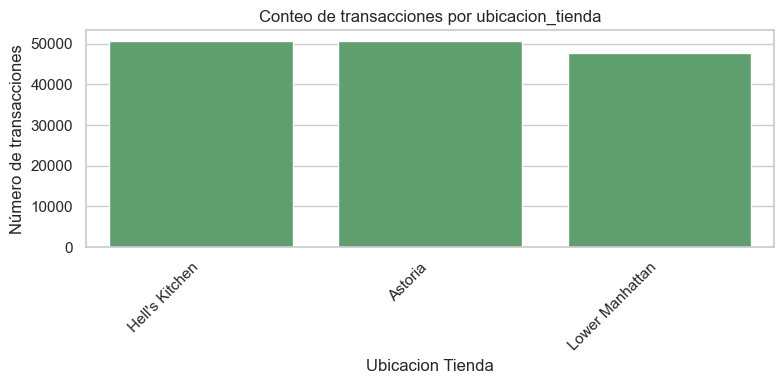

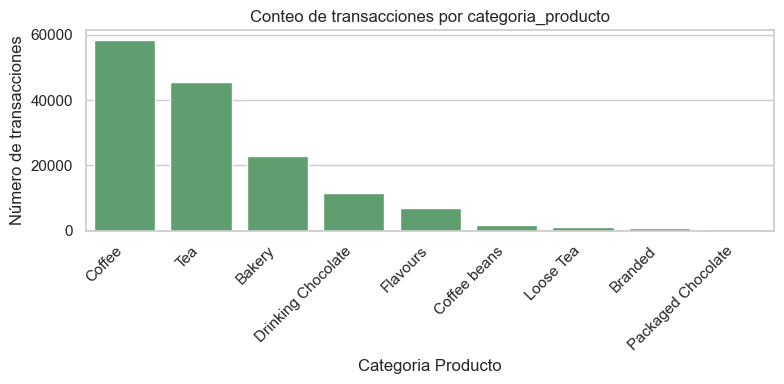

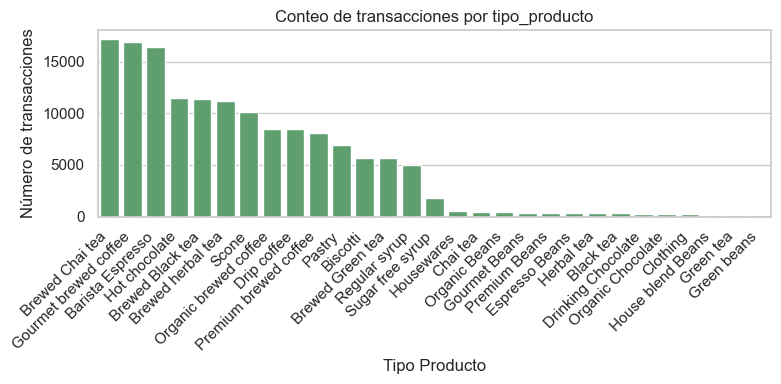

In [16]:
categoricas = ["ubicacion_tienda", "categoria_producto", "tipo_producto"]
for col in categoricas:
    fig, ax = plt.subplots(figsize=(8, 4))
    orden = data[col].value_counts().index
    sns.countplot(data=data, x=col, order=orden, color="#55A868")
    plt.title(f"Conteo de transacciones por {col}")
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel("Número de transacciones")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    fig.savefig(RESULT_DIR / f"conteo_{col}.jpg", dpi=300, format="jpg")
    plt.show()

In [17]:
df_estadistica_descriptiva=df_estadisticas[["Variable","Media","Mediana","Moda","Varianza","Desviación estándar","Rango","Q25","Q50","Q75"]].copy()
df_intervalo_confianza=df_estadisticas[["Variable","Rango","IC 95% Inferior","IC 95% Superior"]].copy()
estadisticos_descriptivos=RESULT_DIR/"estadisticos_descriptivos.html"
intervalos_confianza=RESULT_DIR/"intervalos_confianza.html"

# df_estadistica_descriptiva

df_estadistica_descriptiva.to_html(estadisticos_descriptivos, index=False)
df_intervalo_confianza.to_html(intervalos_confianza, index=False)